This is a partial reproduction of [How Strongly do Dictionary Learning Features Influence Model Behavior?](https://transformer-circuits.pub/2024/april-update/index.html#ablation-exps) by Jack Lindsey, on GPT2-small.

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from teren import utils as teren_utils, lindsey_utils
from teren.typing import *

device = teren_utils.get_device_str()
print(f"{device=}")

device='cuda'


### load the transformer model

In [2]:
from transformer_lens import HookedTransformer

model = HookedTransformer.from_pretrained("google/gemma-2-2b", device=device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


### set experiment parameters

In [3]:
# each layer is kind of independent experiment, but we save a lot of time by
# collecting dataset examples and residual stream activation for many layers at once

# pre-trained SAE model availavle in SAELens

# Joseph Bloom's SAEs
SAE_RELEASE = "gemma-scope-2b-pt-res-canonical"
# pre and post hooks for last layer 11
LAYERS = list(range(model.cfg.n_layers + 1))
LAYER_TO_SAE_ID = lambda layer: (
    "blocks.11.hook_resid_post" if layer == 12 else f"blocks.{layer}.hook_resid_pre"
)

# # OpenAI SAEs
# SAE_RELEASE = "gpt2-small-resid-post-v5-32k"
# LAYERS = list(range(1, model.cfg.n_layers + 1))
# LAYER_TO_SAE_ID = lambda layer: f"blocks.{layer - 1}.hook_resid_post"

LAYERS = (21,)
# HF text  dataset
DATASET_PATH = "NeelNanda/c4-10k"
DATASET_SPLIT = "train[:1%]"#todo 5%

# how long each tokenized prompt should be
CONTEXT_SIZE = 16

# how many tokens can be forwarded through the transformer at once
# tune to your VRAM, 12_800 works well with 16GB
INFERENCE_TOKENS = 12_800
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // CONTEXT_SIZE
print(f"{INFERENCE_BATCH_SIZE=}")

# what is the minimum activation for a feature to be considered active
MIN_FEATURE_ACTIVATION = 0.0
# minimum number of tokenized prompts that should have a feature active
# for the feature to be included in the experiment
MIN_EXAMPLES_PER_FEATURE = 5 # todo 30
# ids of feature to consider in the experiment
# we can't consider all the features, because of compute & memory constraints
CONSIDER_FIDS = [FeatureId(i) for i in range(3)] # todo 30

INFERENCE_BATCH_SIZE=800


### load SAE models, one for each layer

In [4]:
from sae_lens import SAE

sae_by_layer = {
    # ignore other things it returns
    layer: SAE.from_pretrained(
        release=SAE_RELEASE, sae_id=f"layer_{layer-1}/width_16k/canonical", device=device
    )[0]
    for layer in LAYERS
}

In [5]:
all_input_ids = teren_utils.load_and_tokenize_dataset(
    path=DATASET_PATH,
    split=DATASET_SPLIT,
    column_name="text",
    tokenizer=model.tokenizer,  # type: ignore
    max_length=CONTEXT_SIZE,
)
print(f"all_input_ids (tokenized dataset) shape: {tuple(all_input_ids.shape)}")

all_input_ids (tokenized dataset) shape: (3239, 16)


### collect examples, residual stream activations and clean loss

For each layer:
 - find features that were active in at least `MIN_EXAMPLES_PER_FEATURE` tokenized prompts
 - collect these prompts for each feature
 - collect residual stream activation on these prompts
 - compute the loss on these prompts

We're doing it all at once to reduce the number of model inference runs.  
The data is stored in CPU RAM, not VRAM.

In [6]:
from teren.sae_examples import (
    get_sae_feature_examples_by_layer_and_resid_stats_by_layer,
)

sae_feature_examples_by_layer, resid_stats_by_layer = (
    get_sae_feature_examples_by_layer_and_resid_stats_by_layer(
        input_ids=all_input_ids,
        model=model,
        sae_by_layer=sae_by_layer,
        fids=CONSIDER_FIDS,
        n_examples=MIN_EXAMPLES_PER_FEATURE,
        batch_size=INFERENCE_BATCH_SIZE,
        min_activation=MIN_FEATURE_ACTIVATION,
    )
)

# display high-level summary of the data
for layer, sae_feature_examples in sae_feature_examples_by_layer.items():
    print(f"Layer: {layer}")
    active_feature_ids = sae_feature_examples.fids
    print(f"Number of selected features: {len(active_feature_ids)}")
    print(f"Active feature ids: {active_feature_ids}")
    print()

Layer: 21
Number of selected features: 3
Active feature ids: [FeatureId(int=0), FeatureId(int=1), FeatureId(int=2)]



In [7]:
def print_examples_shapes(layer: int):
    print(f"Layer: {layer}")
    examples_by_feature = sae_feature_examples_by_layer[layer]
    print(
        f"input_ids shape: {tuple(examples_by_feature.input_ids.shape)} (n_features, n_examples, context_size)"
    )
    print(
        f"resid_acts shape: {tuple(examples_by_feature.resid_acts.shape)} (n_features, n_examples, context_size, d_model)"
    )
    print(
        f"clean_logits shape: {tuple(examples_by_feature.clean_logits.shape)} (n_features, n_examples, context_size - 1)"
    )


print_examples_shapes(LAYERS[0])

Layer: 21
input_ids shape: (3, 5, 16) (n_features, n_examples, context_size)
resid_acts shape: (3, 5, 16, 2304) (n_features, n_examples, context_size, d_model)
clean_logits shape: (3, 5, 16, 256000) (n_features, n_examples, context_size - 1)


### check if we can reconstruct the loss from saved residual stream activations
If we run the transformer blocks `n, n+1, ..., N-1` starting from activation saved at layer `n`, will we get the same loss as when running the full model?

### main part: apply perturbations

Some perturbations need to be initialized with arguments that depend on specific SAE/layer or even a specific feature id. Some of them don't, but we assume all do and just keep a bunch redundant references for them, to simplify the API.

In [8]:
pert_by_fid_by_name_by_layer = lindsey_utils.get_pert_by_fid_by_name_by_layer(
    sae_feature_examples_by_layer, sae_by_layer, resid_stats_by_layer
)

In [11]:
# losses for all perturbations for all layers
logits_by_pert_by_layer, reference_logits_by_layer = (
    lindsey_utils.compute_logits_by_pert_normalized_by_layer_and_ablate_resid_loss_by_layer(
        model=model,
        sae_feature_examples_by_layer=sae_feature_examples_by_layer,
        pert_by_fid_by_name_by_layer=pert_by_fid_by_name_by_layer,
        batch_size=INFERENCE_BATCH_SIZE,
    )
)

### plot the results

In [12]:
clean_logits_by_layer = {
    layer: sae_feature_examples.clean_logits
    for layer, sae_feature_examples in sae_feature_examples_by_layer.items()
}
results_df = lindsey_utils.compute_results_df(
    logits_by_pert_by_layer=logits_by_pert_by_layer,
    clean_logits_by_layer=clean_logits_by_layer,
    reference_logits_by_layer=reference_logits_by_layer,
)
display(results_df[:20:2])

,pert_name,n_features,layer,loss_seq_max_std,loss_seq_max_mean,loss_seq_max_stderr,loss_seq_mean_std,loss_seq_mean_mean,loss_seq_mean_stderr
0,ablate_sae_feature,3,21,0.109613,0.591401,0.063285,0.013022,0.265677,0.007519
2,toward_sae_recon,3,21,0.110845,0.668899,0.063996,0.017752,0.310293,0.010249
4,naive_random_features,3,21,0.091821,0.556068,0.053013,0.013363,0.257411,0.007715


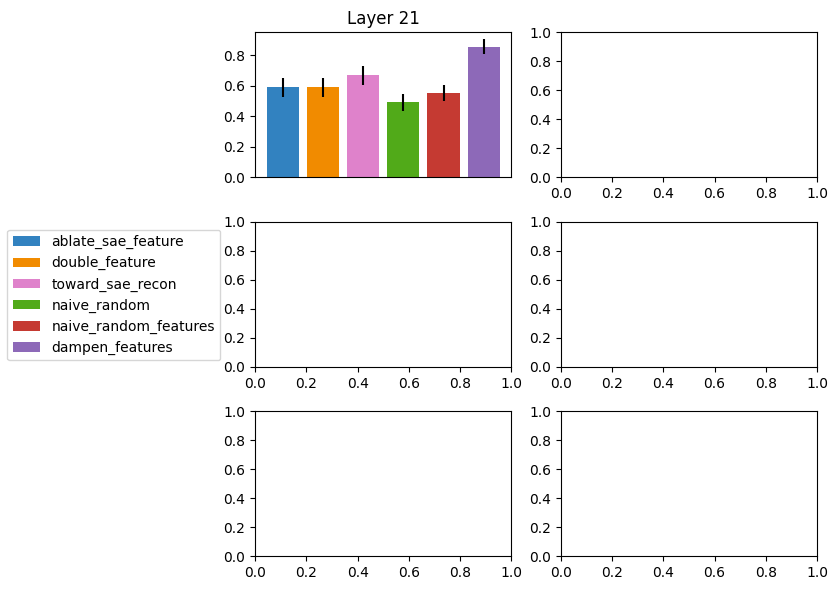

In [13]:
lindsey_utils.plot_results_df(results_df, seq_aggregation="max")

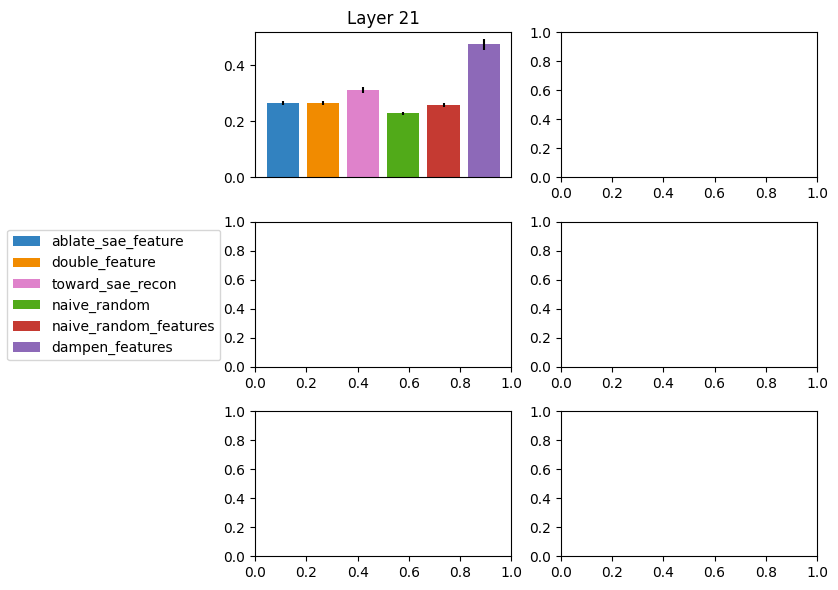

In [14]:
lindsey_utils.plot_results_df(results_df, seq_aggregation="mean")